In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, fnmatch
import shutil
import random as rnd
import librosa
import scipy.signal
import time
import noisereduce as nr
import statistics
import sklearn
from noisereduce.generate_noise import band_limited_noise

from librosa.core import get_duration
from librosa.util import normalize as norm
from librosa import display
from scipy import interpolate
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter as savgol
from sklearn.preprocessing import MinMaxScaler

import IPython.display as ipd

%matplotlib inline

In [2]:
datdir = "/Users/cagrierdem/Desktop/dat/guit_raw_dir/"
img_path = "/Users/cagrierdem/Desktop/dat/modelv2/plots/"
savedir = "/Users/cagrierdem/Desktop/dat/modelv2/coadaptive/npy/"

tasks = ["bending_soft_70",
         "bending_strong_70",
         'on-off_soft_70',
         'on-off_strong_70',
         'sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70']

elmac = 'ef-9d-fd-31-ea-10'
ermac = ['d0-8d-fc-7f-f5-f1', 'c3-0c-f3-14-d7-f0']

participant = []
for people in os.listdir(os.path.join(datdir)):
    if people.startswith('p'):
        participant.append(people)
participant = sorted(participant)

In [3]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

In [4]:
def ffind(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [5]:
def jerk_of(imudat, sr=50, normalize=True):
    
    pre_index = imudat.index
    
    xdiff = np.diff(imudat.iloc[:,4].values)
    ydiff = np.diff(imudat.iloc[:,5].values)
    zdiff = np.diff(imudat.iloc[:,6].values)
    jerk = np.sqrt(xdiff**2 + ydiff**2 + zdiff**2) / 0.005
    jerk = np.reshape(jerk, (jerk.shape[0], 1))
    
    if normalize:
        scaler = MinMaxScaler()
        scaler.fit(jerk)
        jerk_scaled = scaler.transform(jerk)
    else:
        jerk_scaled = jerk
    
    jerk_scaled = pd.DataFrame(data=jerk_scaled, columns=['jerk'])
    jerk_scaled.index = pre_index[:jerk_scaled.shape[0]]
    jerk_scaled.index.name = 'time'
        
    return jerk_scaled

### Import

In [6]:
ffind('*.csv', datdir)

['/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/emg_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/emg_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/emg_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/emg_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_soft_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_soft_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_d

In [7]:
#Find paths for improvisations
fpaths, impros=[],[]
for idx, p in enumerate(participant[:]):
    ppath = os.path.join(datdir, p)
    for t in os.listdir(ppath):
        if t.startswith('f'):
            free_path = os.path.join(ppath, t)
            fpaths.append(free_path)
            impros.append(free_path.split('/')[-1])

In [8]:
impro_tasks = list(dict.fromkeys(impros))
impro_tasks

['free_encore_100',
 'free_70',
 'free',
 'free_encore_70',
 'free_encore_90',
 'free_encore_85',
 'free_encore_120',
 'free_encore_60',
 'free_correct_70',
 'free_encore_140',
 'free_encore_110',
 'free_encore_80']

In [9]:
#All tasks + impros
start_time = time.time()

elall,erall,imulall,imurall,mtall,atall = [],[],[],[],[],[]

all_tasks=[]
all_tasks = tasks + impro_tasks

for idx, p in enumerate(participant):
  
    elpart,erpart,imulpart,imurpart,mtpart,atpart = [],[],[],[],[],[]
    
    for t in all_tasks:
        try:
            file = open(os.path.join(datdir, p, t, 'timeline.txt'), 'r')
            metro_timeline = file.read().split(',')
            metro_timeline = [float(i) for i in metro_timeline]
            file.close()
            mtpart.append(metro_timeline)
            
            file2 = open(os.path.join(datdir, p, t, 'audio_start.txt'), 'r')
            start = float(file2.read())
            file2.close
            atpart.append(start)
        
            rmac = ermac[0] if 'emg_'+ermac[0]+'.csv' in os.listdir(os.path.join(datdir, p, t+'/')) else ermac[1]
            emgl = pd.read_csv(os.path.join(datdir, p, t, 'emg_'+elmac+'.csv'), index_col=0)
            emgr = pd.read_csv(os.path.join(datdir, p, t, 'emg_'+rmac+'.csv'), index_col=0)
            emgl.index.name = 'time'
            emgr.index.name = 'time'
            elpart.append(emgl)
            erpart.append(emgr)

            imul = pd.read_csv(os.path.join(datdir, p, t, 'imu_'+elmac+'.csv'), index_col=0)
            imur = pd.read_csv(os.path.join(datdir, p, t, 'imu_'+rmac+'.csv'), index_col=0)
            imul.index.name = 'time'
            imur.index.name = 'time'
            imulpart.append(imul)
            imurpart.append(imur)
        except:
            pass

    elall.append(elpart)
    erall.append(erpart)
    imulall.append(imulpart)
    imurall.append(imurpart)
    mtall.append(mtpart)
    atall.append(atpart)
    
    printProgressBar(idx,len(participant),"completed")

print("\n")
print("Execution of this program took %s seconds." % (time.time() - start_time))

[========= ] 96%  completed

Execution of this program took 81.19827103614807 seconds.


##### Note:
One usually wants to filter first, normalize next (since the normalization may change depending on the DC response of the filter), then segment (so only the first segment(s) incur the filter's initial transient response).

In [10]:
task_qty=[]
for i,p in enumerate(participant):
    task_qty.append([p, len(erall[i])])
task_qty

[['p01', 10],
 ['p02', 9],
 ['p03', 10],
 ['p04', 10],
 ['p05', 11],
 ['p06', 10],
 ['p07', 10],
 ['p08', 11],
 ['p09', 11],
 ['p10', 11],
 ['p11', 10],
 ['p12', 11],
 ['p13', 11],
 ['p14', 10],
 ['p15', 11],
 ['p16', 10],
 ['p17', 10],
 ['p18', 10],
 ['p19', 10],
 ['p20', 10],
 ['p21', 10],
 ['p22', 10],
 ['p23', 10],
 ['p24', 11],
 ['p25', 10],
 ['p26', 10],
 ['p27', 10],
 ['p28', 10],
 ['p29', 10],
 ['p30', 11],
 ['p31', 10],
 ['p32', 10]]

In [11]:
# #to be used with different amounts of tasks per participant

# for i,p in enumerate(task_qty):
    
#     for t in range(p[1]):
        
#         print(erall[i][t].shape, p[0], t)

In [12]:
# [ffind('*.csv', fpaths[i]) for i in range(len(fpaths))]

In [13]:
# #Only impros

# start_time = time.time()

# fmt, fat, fel, fer, fimul, fimur = [],[],[],[],[],[]

# for idx, path in enumerate(fpaths):
    
#     try:
#         rmac = ermac[0] if 'emg_'+ermac[0]+'.csv' in os.listdir(os.path.join(path+'/')) else ermac[1]
#         emgl = pd.read_csv(os.path.join(path, 'emg_'+elmac+'.csv'), index_col=0)
#         emgr = pd.read_csv(os.path.join(path, 'emg_'+rmac+'.csv'), index_col=0)
#         emgl.index.name = 'time'
#         emgr.index.name = 'time'
#         fel.append(emgl)
#         fer.append(emgr)

#         imul = pd.read_csv(os.path.join(path, 'imu_'+elmac+'.csv'), index_col=0)
#         imur = pd.read_csv(os.path.join(path, 'imu_'+rmac+'.csv'), index_col=0)
#         imul.index.name = 'time'
#         imur.index.name = 'time'
#         fimul.append(imul)
#         fimur.append(imur)
#     except:
#         pass

#     printProgressBar(idx, len(fpaths),"completed")

# print("\n")
# print("Execution of this program took %s seconds." % (time.time() - start_time))

In [14]:
# plt.figure(figsize=(24,7))
# plt.plot(erpart[0]);

### Pre-process

In [15]:
def align(df, audio_timeline, metro_timeline, beat_to_cut=7, end=False):
    
    #get the timestamp for desired beat point to cut:
    cut_point = metro_timeline[beat_to_cut] 
    
    #eliminate the lag between the metro start time and audio start time
    new_metro_timeline = [t - audio_timeline for t in metro_timeline]
    
    #cut the dataframe based on the timestamp of the chosen beat
    new_df = df[df.index >= cut_point]
    
    # reset the start index to zero by substracting the start time of the chosen beat
    s = new_df.index[0]
    new_df.index = [t - s for t in new_df.index]
    
    #optional: find the sample nr of the end-cut point, which is the same amount of bars as the first cut:
    if end:
        end_cut = (np.abs(new_df.index-(new_df.index[-1] - cut_point))).argmin()
        new_df = new_df.iloc[:end_cut,:]
    else:
        new_df = new_df
    
    return new_df

In [16]:
def sync_comb(df, ref_df, how='right'):
    
    col_nr = df.shape[1]
    
    #find the nearest points in the timeline of the given dataframe
    time_points=[]
    for val in df.index:
        idx = (np.abs(ref_df.index-val)).argmin()
        time_points.append(ref_df.index.values[idx])
    
    new_df = df.copy()
    new_df.index = time_points
    
    combined = new_df.join(ref_df, how=how)
    combined_i = combined.interpolate(method='index')
    
    return combined_i.iloc[:,:col_nr], combined_i.iloc[:,col_nr:]

In [17]:
def sknorm(x, axis=0, feature_range=(-1, 1), df=True):
    scaled = sklearn.preprocessing.minmax_scale(x, axis=axis, feature_range=feature_range)
    if df:
        scaled = pd.DataFrame(data=scaled)
        scaled.index=x.index
        scaled.columns = x.columns
    else:
        scaled = scaled
    return scaled

In [18]:
def inter(df, freq=200):
    x = df.index
    
    #interpolation
    x_new = np.linspace(start=x[0], stop=x[-1], num=int((x[-1] - x[0])*freq))

    inter = []
    for col in df.columns:
        y = df[col]
        func = interpolate.interp1d(x, y)
        y_new = func(x_new)
        inter.append(y_new)
    inter = np.array(inter).transpose()
    inter = pd.DataFrame(data=inter, columns=[list(df)[i] for i in range(df.shape[1])], index=x_new)
#     print(1/np.mean(np.diff(inter.index))) #find freq of sig
    return inter

In [19]:
def matchLR(dfL,dfR):
    if dfL.shape[0] > dfR.shape[0]:
        dfL = dfL.iloc[:dfR.shape[0],:]
    else:
        dfR = dfR.iloc[:dfL.shape[0],:]
    return dfL,dfR

In [20]:
def get_time(y, sr=200):
    return np.linspace(0, len(y)/sr, len(y))

In [21]:
def fnan(df):
    return df.isnull().sum().sum()

In [22]:
start_time = time.time()

data_list=[]
for i,p in enumerate(task_qty[:]):
    
    concats=[]
    for t in range(p[1]):
        
        s, m = atall[i][t], mtall[i][t]
        el, er = elall[i][t].copy(), erall[i][t].copy(),
        il, ir = imulall[i][t].iloc[:,4:].copy(), imurall[i][t].iloc[:,4:].copy()
        cut = 7 #nth beat
        
        #cut 3 bars from beginning and end & align
        lemg = align(el, s, m, cut, end=True); remg = align(er, s, m, cut, end=True)
        limu = align(il, s, m, cut, end=True); rimu = align(ir, s, m, cut, end=True)
        
        #scale & sync IMU to EMG (note: EMG is already within (-1,1) range)
        limu, lemg = sync_comb(sknorm(limu), lemg)
        rimu, remg = sync_comb(sknorm(rimu), remg)
        
        #interpolate & make L and R same length
        limu, rimu = matchLR(inter(limu), inter(rimu))
        lemg, remg = matchLR(inter(lemg), inter(remg))
        
        #reset index
        limu.index = get_time(limu); rimu.index = get_time(rimu)
        lemg.index = get_time(lemg); remg.index = get_time(remg)
        
        #make into a single df & backfill NaNs
        concat = pd.concat([lemg, limu.fillna(method='bfill'), 
                            remg, rimu.fillna(method='bfill')], axis=1)
        new_cols=[]
        for idx,col in enumerate(list(concat)):
            if idx < 14:
                name = col+'_L'
            else:
                name = col+'_R'
            new_cols.append(name)
        concat.columns = [c for c in new_cols]
        concats.append(concat)

    data_list.append(concats)
    
    printProgressBar(i,len(task_qty),"completed")

print("\n")
print("Execution of this program took %s seconds." % (time.time() - start_time))

[========= ] 96%  completed

Execution of this program took 1686.4220888614655 seconds.


In [23]:
peep=7

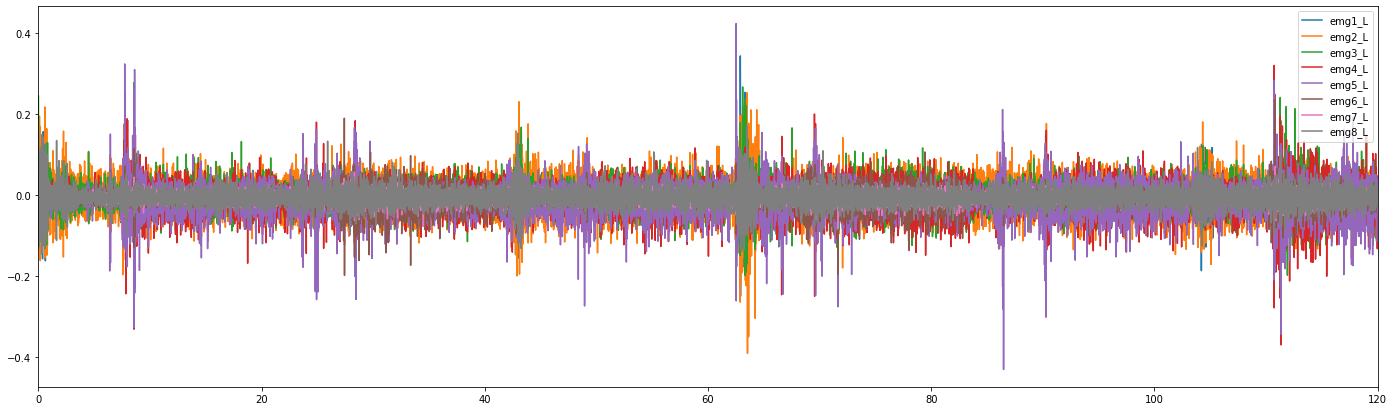

In [24]:
data_list[peep][5].iloc[:,:8].plot(figsize=(24,7))

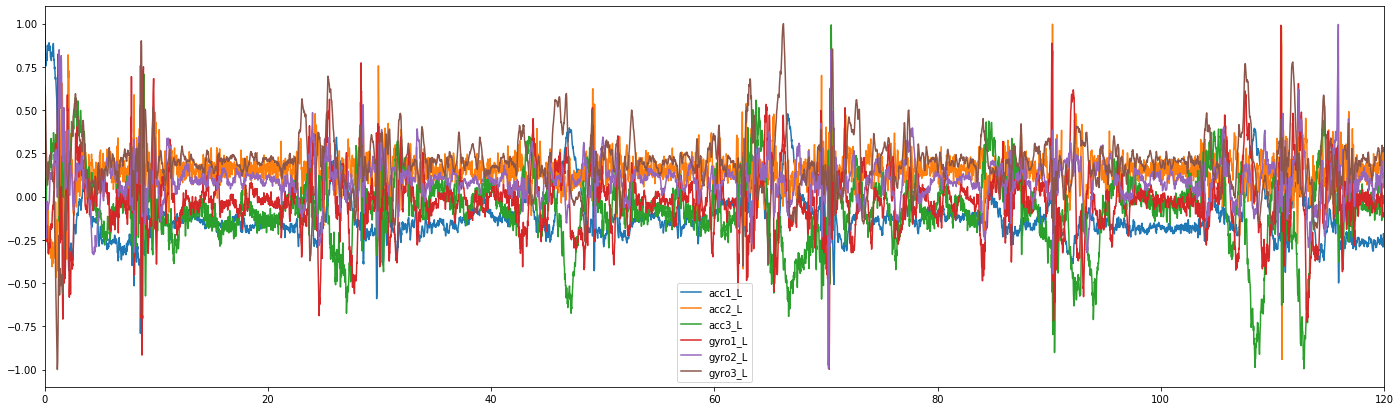

In [29]:
data_list[peep][5].iloc[:,8:14].plot(figsize=(24,7))

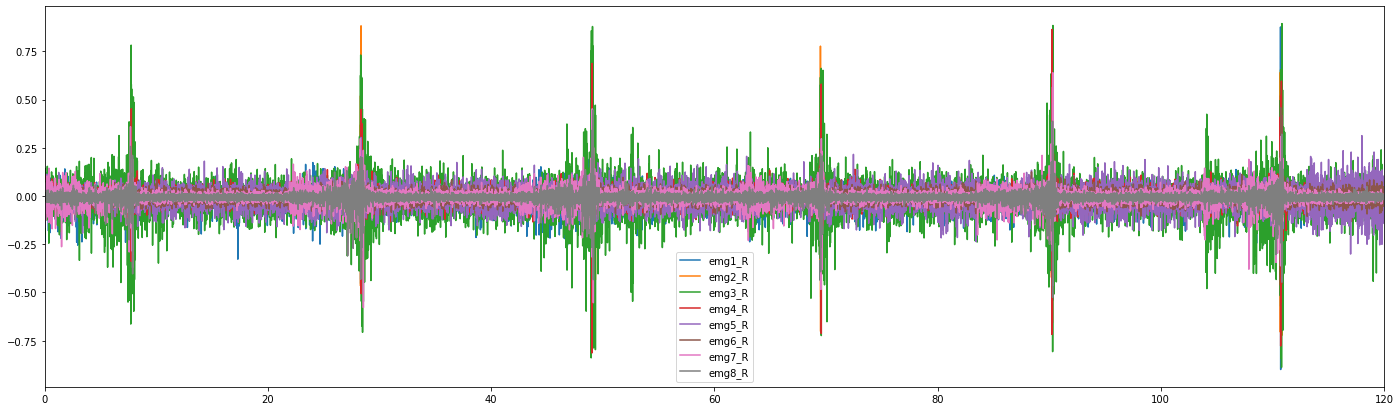

In [32]:
data_list[peep][5].iloc[:,14:22].plot(figsize=(24,7))

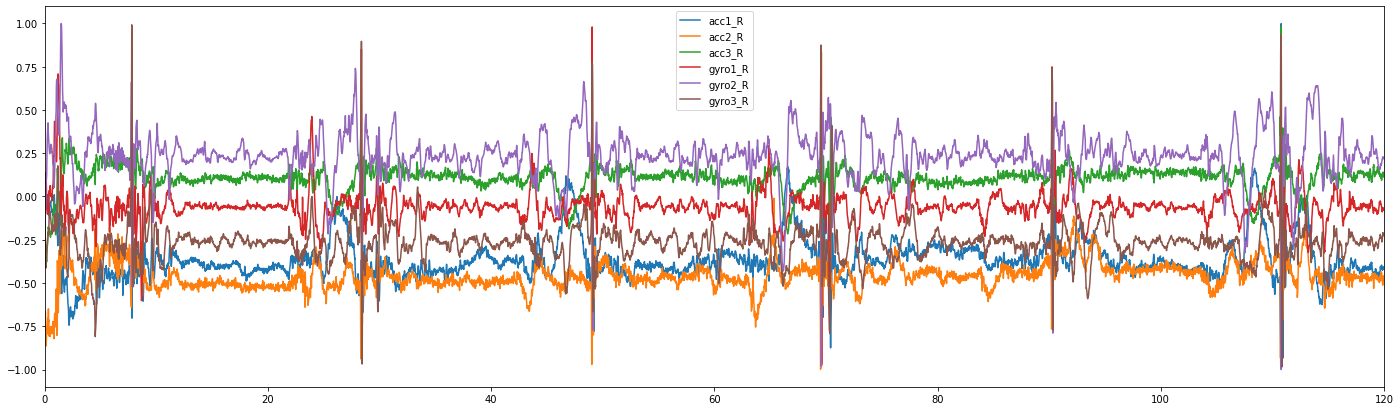

In [33]:
data_list[peep][5].iloc[:,22:].plot(figsize=(24,7))

### Export

In [35]:
decision = input('–Do you want to export? \n –')

if decision.startswith('y'):
    nr=0
    dataset_info=[]
    for i,p in enumerate(task_qty):
        for t in range(p[1]):
            nr += 1
            array = data_list[i][t].to_numpy()
            #save npy files
            np.save(os.path.join(savedir, 'sample_'+str(nr)), array)  
            dataset_info.append(str(nr) + '-' + str(p[0]) + '-' + str(all_tasks[t]))

    #save a txt file with the data info
    with open(os.path.join(savedir, "dataset_info.txt"), "w") as text_file:
        print(' \n'.join([str(elem) for elem in dataset_info]) , file=text_file)
else:
    pass

–Do you want to export? 
 –yes
